# Datenaufbereitung
Es werden Daten geladen und aufbereitet, näheres dazu lässt sich in der Arbeit lesen

#### Allgemeines Setup des Notebooks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from pandas import read_csv
from sklearn.utils import shuffle
from datetime import datetime
from pandas.core.computation.check import NUMEXPR_INSTALLED
import seaborn as sns

### Cleaned Data without changes

### 1. Daten werden geladen

In [193]:
#lade einfache Daten und wandle in einen Dataframe um
with open('fullData.json') as dataJson:
    data = json.load(dataJson)

In [194]:
df_data = pd.DataFrame(data)
df = df_data[df_data['session'].notna()]

df.head()

,clientId,elementId,timeStamp,type,siteName,date,clientX,clientY,session,height,width,browser,key
339,2567c85a-ad16,inputPet,824.2999999988824,mouseover,TestEinfach,2022-10-17T13:35:24.171Z,673,363,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,NaN,NaN
340,2567c85a-ad16,inputPet,858.2999999988824,mouseout,TestEinfach,2022-10-17T13:35:24.205Z,772,333,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,NaN,NaN
341,2567c85a-ad16,inputCountry,2005.2999999988824,mouseover,TestEinfach,2022-10-17T13:35:25.361Z,796,266,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,NaN,NaN
342,2567c85a-ad16,inputCountry,2296.5,focus,TestEinfach,2022-10-17T13:35:25.652Z,NaN,NaN,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,Chrome,NaN
343,2567c85a-ad16,inputHouse,2875.2999999988824,mouseover,TestEinfach,2022-10-17T13:35:26.230Z,995,264,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,NaN,NaN


### 2. Bereinigung der Daten

#### 2.1 Alle Ereignisse abrufen, die sich tatsächlich in TestSchwer befinden

In [195]:
#get all events which are actually in TestSchwer
array_input_schwer = ['inputHobby','inputCancelor','inputTemperature','inputDays','inputRiver', 'inputDifficultQuestion', 'clickHere', 'buttonYes', 'alibiClick']

df_einfach_without_schwerInput = df[~df['elementId'].isin(array_input_schwer)]
df_schwer_without_einfachInput = df[df['elementId'].isin(array_input_schwer)]

df_actually_schwer = df_einfach_without_schwerInput.loc[df_einfach_without_schwerInput['siteName'] == 'TestSchwer']
df_easy = df_actually_schwer.assign(sitename='TestSchwer')

df_einfach = df_einfach_without_schwerInput.loc[~(df_einfach_without_schwerInput['siteName'] == 'TestSchwer')]
df_schwer = pd.concat([df_easy, df_schwer_without_einfachInput])
df_schwer['siteName'] = 'TestSchwer'

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

#### 2.2 Gleich viele Sessions bei TestSchwer & TestEinfach

In [196]:
sessionIdSchwer = df_schwer['session']
sessionIdEinfach = df_einfach['session']

df_einfach['is_duplicated'] = df_einfach.duplicated('session')
#89 ids auf Seite Einfach
setEinfach = set(sessionIdEinfach)
length = len(setEinfach)
print(length)

#70 ids auf Seite Schwer
df_schwer['is_duplicated'] = df_schwer.duplicated('session')
setSchwer = set(sessionIdSchwer)
lengthSchwer = len(setSchwer)
print(lengthSchwer)

89
70


<ipython-input-196-2d14dad677d7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_einfach['is_duplicated'] = df_einfach.duplicated('session')


In [197]:
in_schwer_but_not_in_einfach = setSchwer - setEinfach
in_einfach_but_not_in_schwer = setEinfach - setSchwer

array_einfach = list(in_einfach_but_not_in_schwer)
array_schwer = list(in_schwer_but_not_in_einfach)

#66 Teilnehmer bzw. Sessions
df_einfach_without_ids = df_einfach[~df_einfach['session'].isin(array_einfach)]
df_schwer_without_ids = df_schwer[~df_schwer['session'].isin(array_schwer)]

df_einfach_final = df_einfach_without_ids.drop(['clientId', 'is_duplicated'], axis=1)
df_schwer_final = df_schwer_without_ids.drop(['clientId', 'is_duplicated'], axis=1)

print("Anzahl der Session-Ids bei einfach", 89 - len(array_einfach))
print("Anzahl der Session-Ids bei schwer",70 - len(array_schwer))

Anzahl der Session-Ids bei einfach 66
Anzahl der Session-Ids bei schwer 66


In [205]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# print(df_einfach_final['session'].value_counts())
# print('Anzahl der Events von TestEinfach:',len(df_einfach_final))

df_concat_data = pd.concat([df_schwer_final, df_einfach_final])

df_concat_data['session'].value_counts()

35164


2e506528-adcc-8870-92ab-5c8d36f84add    4564
b721640b-042e-77a9-9864-28c0ce5264fb    2960
6c81bd46-f25a-08fe-9f88-6652cefdf249    2538
69e4a6b4-0c82-f9be-c9d2-ea959fb5ac90    1715
90ab4d9b-1f2b-12d8-0607-da60d299f472    1629
69e36b9c-46ec-e499-4a8c-9590b2ca8695    1548
2f9a0db6-ed11-77c2-94f9-1a462c4004b1    1523
23fb8e31-17a2-a5c9-8232-5104c42251c3    1389
3490f2c5-6d41-609d-d66f-958156ce1032    1341
41f22727-0a74-d41b-d6c2-29936806a037    1124
73f14012-51c7-29f2-ffcd-3a471f158f6c     944
b39c4e93-1151-131b-4986-6640f58aabcd     943
ea50816c-8d4f-5629-a078-c048513d4fd6     915
c754a47e-7e25-d8fa-3899-8ff89e536e00     876
42420a4b-f28f-de0e-e0e6-9cbb17f84bac     829
08b4135b-f3c7-134f-c91c-444ffa1c7a66     622
b4495cfa-6932-688d-d585-91c5401fbe15     547
057dc296-346a-f2ee-76a7-09440b8283b8     516
8d2b76c5-dc00-9102-8ff2-56cc200482f9     453
849db5c6-9138-0fdc-1a4b-86e89ab9acd3     382
1f3b475d-18e7-6299-b665-534a5e8c7238     379
bc7b7328-1a59-8b98-b75c-4c9ea7c82102     378
56466429-1

In [ ]:
print(df_schwer_final['session'].value_counts())
print('Anzahl der Events von TestSchwer:',len(df_schwer_final))

2e506528-adcc-8870-92ab-5c8d36f84add    4338
b721640b-042e-77a9-9864-28c0ce5264fb    2780
6c81bd46-f25a-08fe-9f88-6652cefdf249    2263
69e4a6b4-0c82-f9be-c9d2-ea959fb5ac90    1678
90ab4d9b-1f2b-12d8-0607-da60d299f472    1591
2f9a0db6-ed11-77c2-94f9-1a462c4004b1    1403
23fb8e31-17a2-a5c9-8232-5104c42251c3    1355
3490f2c5-6d41-609d-d66f-958156ce1032    1165
41f22727-0a74-d41b-d6c2-29936806a037    1023
69e36b9c-46ec-e499-4a8c-9590b2ca8695     953
73f14012-51c7-29f2-ffcd-3a471f158f6c     912
b39c4e93-1151-131b-4986-6640f58aabcd     909
c754a47e-7e25-d8fa-3899-8ff89e536e00     839
42420a4b-f28f-de0e-e0e6-9cbb17f84bac     675
ea50816c-8d4f-5629-a078-c048513d4fd6     662
b4495cfa-6932-688d-d585-91c5401fbe15     529
08b4135b-f3c7-134f-c91c-444ffa1c7a66     490
057dc296-346a-f2ee-76a7-09440b8283b8     465
8d2b76c5-dc00-9102-8ff2-56cc200482f9     431
1f3b475d-18e7-6299-b665-534a5e8c7238     359
56466429-1c10-957b-2ae8-99a5b6a75e95     355
bc7b7328-1a59-8b98-b75c-4c9ea7c82102     350
67cc623a-2

#### 2.3 Diskrepanz der Daten analysieren

In [ ]:
df_concat_data = pd.concat([df_schwer_final, df_einfach_final])

Text(0.5, 1.0, 'Count for Events')

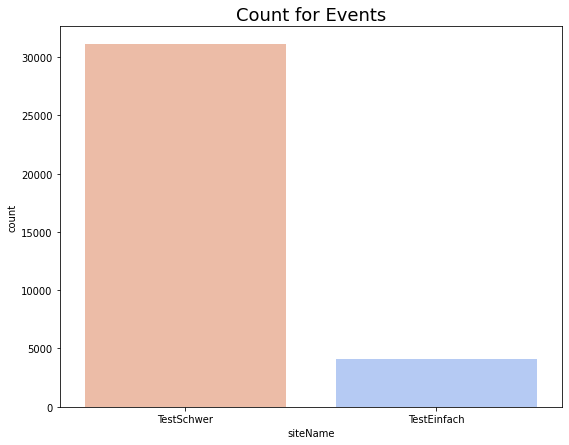

In [ ]:
# Figure size
plt.figure(figsize=(9,7))
# Count plot
ax = sns.countplot(x = 'siteName', data = df_concat_data, palette="coolwarm_r")
# Add title
plt.title('Count for Events', fontsize=18)

Text(0.5, 1.0, 'Counts for Types')

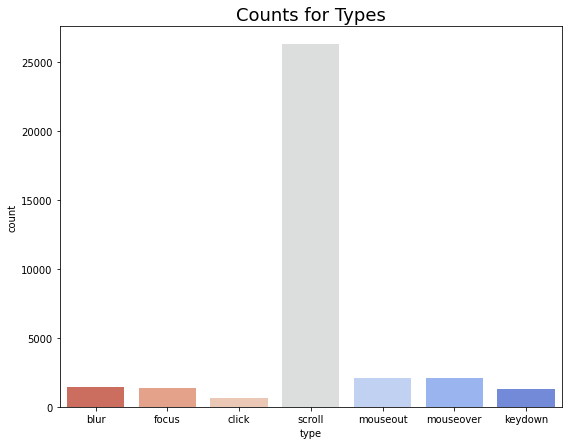

In [ ]:
# Figure size
plt.figure(figsize=(9,7))
# Count plot
ax = sns.countplot(x = 'type', data = df_concat_data, palette="coolwarm_r")
# Add title
plt.title('Counts for Types', fontsize=18)

In [ ]:
df_einfach_final = df_einfach_final.loc[df_einfach_final["type"] !="scroll"]
df_schwer_final = df_schwer_final.loc[df_schwer_final["type"] !="scroll"]

In [ ]:
print('Anzahl der Events ohne Scroll von TestEinfach:',len(df_einfach_final))
print('Anzahl der Events ohne Scroll von TestSchwer:',len(df_schwer_final))

Anzahl der Events ohne Scroll von TestEinfach: 1603
Anzahl der Events ohne Scroll von TestSchwer: 7279


#### 2.4 Werte in float umwandeln

In [ ]:
array_of_properties = ['timeStamp', 'clientX', 'clientY', 'height', 'width']

In [ ]:
def toFloat(test, array):
    for x in range(5): 
        test[array[x]] = test[array[x]].astype(float)
    test['date'] = test['date'].astype('datetime64[ns]')

toFloat(df_einfach_final, array_of_properties)
toFloat(df_schwer_final, array_of_properties)

#### 2.5 Fehlende Werte entfernen

/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:238: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  curves.iloc[:, cols] = (curves
/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<Figure size 720x432 with 0 Axes>

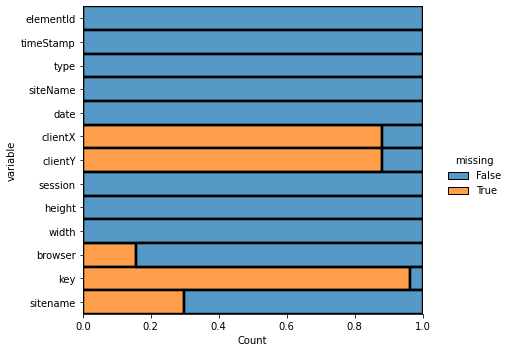

In [ ]:
plt.figure(figsize=(10,6))
sns.displot(
    data=df_concat_data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)

In [ ]:
df_einfach_final = df_einfach_final.drop(['key', 'browser'], axis=1)
df_schwer_final = df_schwer_final.drop(['key', 'browser', 'sitename'], axis=1)

In [ ]:
df_einfach_final['clientX'].fillna((df_einfach_final['clientX'].mean()), inplace=True)
df_einfach_final['clientY'].fillna((df_einfach_final['clientY'].mean()), inplace=True)

df_schwer_final['clientX'].fillna((df_schwer_final['clientX'].mean()), inplace=True)
df_schwer_final['clientY'].fillna((df_schwer_final['clientY'].mean()), inplace=True)

In [ ]:
df_concat_data = pd.concat([df_einfach_final, df_schwer_final])

/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:238: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  curves.iloc[:, cols] = (curves
/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<Figure size 720x432 with 0 Axes>

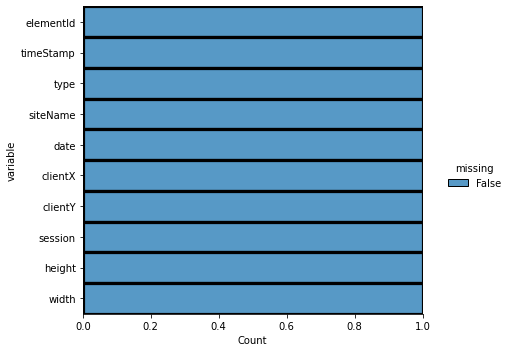

In [ ]:
#test if something is missing 
plt.figure(figsize=(10,6))
sns.displot(
    data=df_concat_data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)

In [ ]:
df_einfach_final['siteName'] = 0
df_schwer_final['siteName'] = 1

df_concat_data = pd.concat([df_einfach_final, df_schwer_final])

In [ ]:
df_schwer_final = df_schwer_final.loc[(df_schwer_final['timeStamp'] < 3000000)]

#### 2.6 Neue Ids vergeben

In [ ]:
# new sessionId 
import random
from random import choice
import collections

array_of_ids_einfach = df_einfach_final['session'].value_counts().index.tolist()
array_of_ids_schwer = df_schwer_final['session'].value_counts().index.tolist()
numbers_schwer = []

random_numbers_ids_einfach = random.sample(range(101,1000), len(array_of_ids_einfach))
for i in range(len(random_numbers_ids_einfach)):
    random_numbers_ids_schwer = random.choice([i for i in range(101, 1000) if i not in random_numbers_ids_einfach])
    numbers_schwer.append(random_numbers_ids_schwer)

numbers = random_numbers_ids_einfach + numbers_schwer

df_einfach_final['session'] = df_einfach_final['session'].replace(array_of_ids_einfach, random_numbers_ids_einfach)
df_schwer_final['session'] = df_schwer_final['session'].replace(array_of_ids_schwer, numbers_schwer)

print([item for item, count in collections.Counter(numbers).items() if count > 1])

[993]


In [ ]:
df_concat_data = pd.read_pickle('CleanedDataWithIds.pkl')
df_einfach_final = df_concat_data.loc[df_concat_data['siteName'] == 0]
df_schwer_final = df_concat_data.loc[df_concat_data['siteName'] == 1]

df_concat_data = pd.concat([df_einfach_final, df_schwer_final])

In [ ]:
df_concat_data.head()

,elementId,timeStamp,type,siteName,date,clientX,clientY,session,height,width
339,inputPet,824.3,mouseover,0,2022-10-17 13:35:24.171,673.000000,363.000000,243,944.0,1920.0
340,inputPet,858.3,mouseout,0,2022-10-17 13:35:24.205,772.000000,333.000000,243,944.0,1920.0
341,inputCountry,2005.3,mouseover,0,2022-10-17 13:35:25.361,796.000000,266.000000,243,944.0,1920.0
342,inputCountry,2296.5,focus,0,2022-10-17 13:35:25.652,526.105402,333.262187,243,944.0,1920.0
343,inputHouse,2875.3,mouseover,0,2022-10-17 13:35:26.230,995.000000,264.000000,243,944.0,1920.0


### 2.7 Checken ob blur bei window nur auf schwerer Seite gesendet wurde

In [219]:
df_einfach_final['type'].value_counts()

scroll       2483
mouseover     380
mouseout      379
blur          375
focus         374
keydown        91
click           4
Name: type, dtype: int64

In [218]:
df_schwer_final['type'].value_counts()

scroll       23799
mouseover     1706
mouseout      1696
keydown       1222
blur          1028
focus         1002
click          625
Name: type, dtype: int64

In [216]:
df_blur = df_schwer_final.loc[(df_schwer_final['elementId'] == 'window') & (df_schwer_final['type'] == 'blur')]

print(len(df_blur['elementId']))

204


### 3.0 Explorative Datenanalyse

/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 90.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 90.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 87.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


KeyboardInterrupt: 

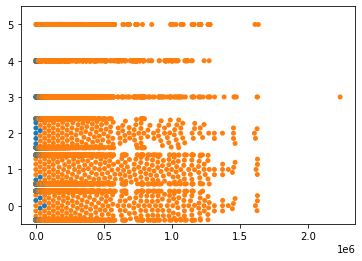

In [ ]:
#fig2 = plt.subplots(1, figsize=(30,8), sharey=True)

#sns.relplot(data=df_einfach_final, x='timeStamp', y='type', color='black')
#sns.relplot(data=df_schwer_final, x='timeStamp', y='type', color='red')

sns.swarmplot(data=df_concat_data, x='timeStamp', y='type', hue="siteName")


In [ ]:
df_schwer_final = df_schwer_final.sort_values(['type'])
df_einfach_final = df_einfach_final.sort_values(['type'])

### 3.1 Untersuchung der Types je nach Seite

<AxesSubplot: xlabel='type', ylabel='count'>

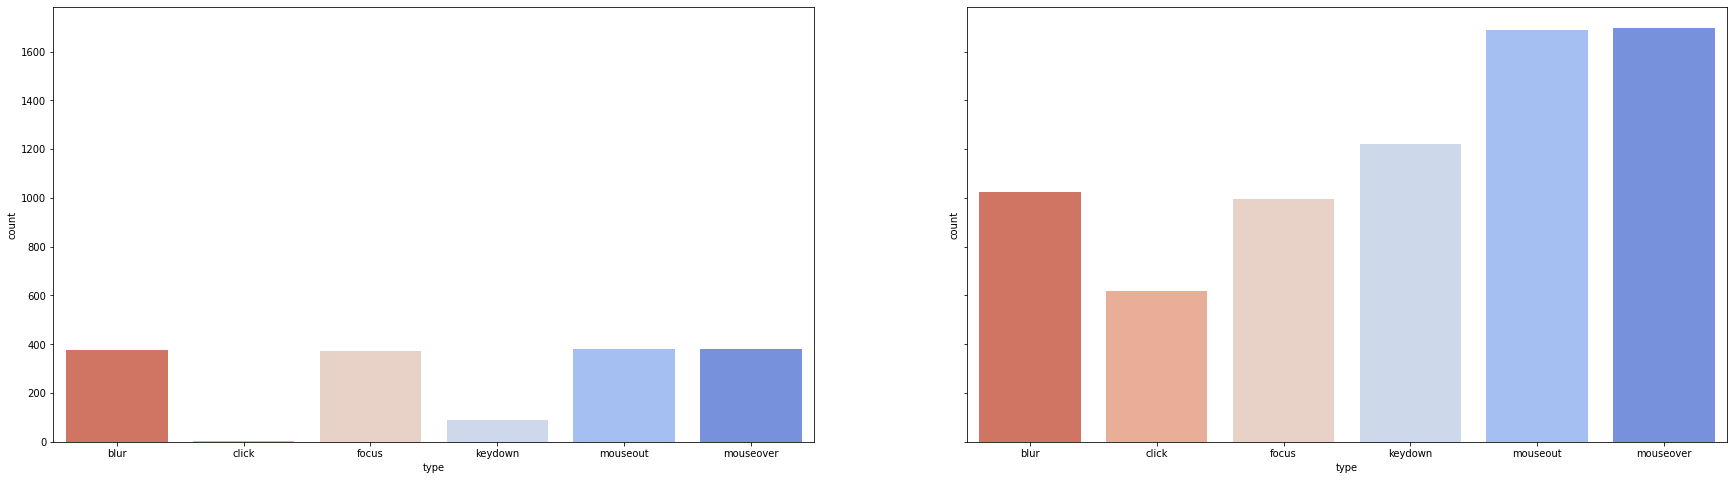

In [ ]:
fig2, axs2 = plt.subplots(1,2, figsize=(30,8), sharey=True)

# Count plot
sns.countplot(x = 'type', data = df_einfach_final, palette="coolwarm_r", ax=axs2[0])
sns.countplot(x = 'type', data = df_schwer_final, palette="coolwarm_r", ax=axs2[1])

In [ ]:
df_schwer_final.head()

,elementId,timeStamp,type,siteName,date,clientX,clientY,session,height,width
365,window,1393.7,blur,1,2022-10-17 13:38:09.616,634.657848,460.161082,889,944.0,1920.0
10505,inputRiver,856723.0,blur,1,2022-10-19 06:42:56.974,634.657848,460.161082,360,866.0,1439.0
10495,inputRiver,183603.0,blur,1,2022-10-19 06:42:48.214,634.657848,460.161082,419,1087.0,1655.0
10465,inputRiver,166623.0,blur,1,2022-10-19 06:42:31.233,634.657848,460.161082,419,1087.0,1655.0
24974,window,754256.6,blur,1,2022-10-22 07:40:12.576,634.657848,460.161082,949,478.0,412.0


### 3.2 Korrelationsmatrix

In [ ]:
one_hot_encoded_data = pd.get_dummies(df_concat_data, columns = ['type'])
one_hot_encoded_data = one_hot_encoded_data.drop(['elementId'], axis=1)

In [ ]:
one_hot_encoded_data.corr()

<ipython-input-101-579b4a4dc715>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  one_hot_encoded_data.corr()


,timeStamp,siteName,clientX,clientY,session,height,width,type_blur,type_click,type_focus,type_keydown,type_mouseout,type_mouseover
timeStamp,1.000000,0.329996,0.036988,0.210926,0.196943,0.034366,0.104407,-0.053051,0.069092,-0.058207,0.039581,0.015062,0.005484
siteName,0.329996,1.000000,0.188070,0.420133,0.068294,0.143694,0.116168,-0.097732,0.124770,-0.101843,0.120929,-0.003105,-0.002412
clientX,0.036988,0.188070,1.000000,0.286275,0.055500,0.431011,0.492302,-0.018186,0.023633,-0.018963,0.022981,0.005494,-0.007150
clientY,0.210926,0.420133,0.286275,1.000000,0.112796,0.259546,0.218314,-0.040977,0.052492,-0.042705,0.050909,0.006574,-0.009149
session,0.196943,0.068294,0.055500,0.112796,1.000000,0.187997,0.226192,-0.033864,0.030758,-0.028265,-0.047139,0.038103,0.036186
height,0.034366,0.143694,0.431011,0.259546,0.187997,1.000000,0.824583,-0.076300,0.029663,-0.043641,-0.053632,0.054306,0.075762
width,0.104407,0.116168,0.492302,0.218314,0.226192,0.824583,1.000000,-0.071240,0.029691,-0.063744,-0.054089,0.073298,0.069976
type_blur,-0.053051,-0.097732,-0.018186,-0.040977,-0.033864,-0.076300,-0.071240,1.000000,-0.119184,-0.185598,-0.180686,-0.239301,-0.240132
type_click,0.069092,0.124770,0.023633,0.052492,0.030758,0.029663,0.029691,-0.119184,1.000000,-0.117764,-0.114647,-0.151839,-0.152366
type_focus,-0.058207,-0.101843,-0.018963,-0.042705,-0.028265,-0.043641,-0.063744,-0.185598,-0.117764,1.000000,-0.178534,-0.236450,-0.237271


<ipython-input-102-dfc742ac5623>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(one_hot_encoded_data.corr(), vmin=-1, vmax=1, annot=True)


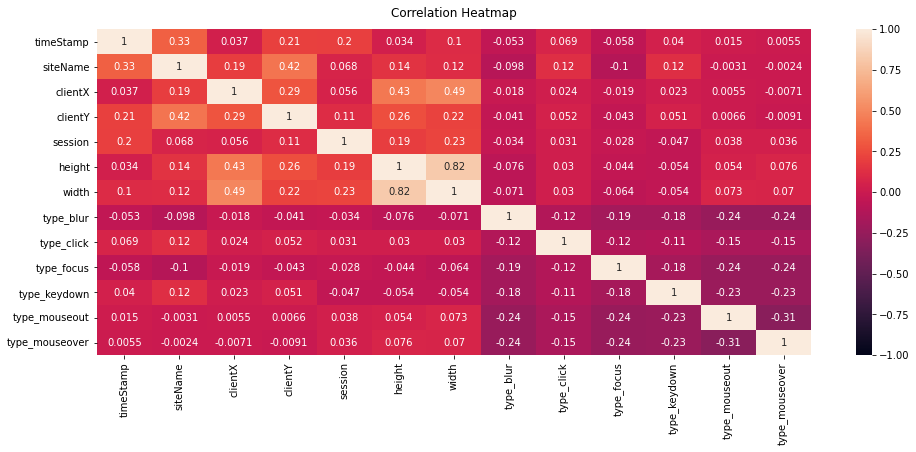

In [ ]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(one_hot_encoded_data.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
df_sessions = pd.read_pickle('SortedBySessions.pkl')
one_hot_encoded_data_sessions = pd.get_dummies(df_sessions, columns = ['siteName'])

In [ ]:
df_sessions.head()

,session,count_mouseover,count_mouseout,count_click,count_blur,count_focus,count_keydown,duration,height,width,siteName
0,515,32,32,14,26,28,27,136.831,1312.0,1479.0,1
1,519,1,0,0,1,1,0,33.249,669.0,390.0,1
2,524,42,42,8,17,16,5,230.175,878.0,1920.0,1
3,528,4,3,0,6,6,0,20.563,1217.0,1440.0,0
4,554,6,6,0,6,6,0,17.076,715.0,414.0,0


In [ ]:
one_hot_encoded_data_sessions.corr()

,session,count_mouseover,count_mouseout,count_click,count_blur,count_focus,count_keydown,duration,height,width,siteName_0,siteName_1
session,1.000000,0.185343,0.186416,0.184452,0.145906,0.153380,0.053493,0.016331,0.132333,0.050573,0.117198,-0.117198
count_mouseover,0.185343,1.000000,0.999953,0.678188,0.926356,0.932775,0.740002,0.690807,0.188989,0.219447,-0.371347,0.371347
count_mouseout,0.186416,0.999953,1.000000,0.678011,0.925720,0.932279,0.738296,0.689657,0.190539,0.222031,-0.368353,0.368353
count_click,0.184452,0.678188,0.678011,1.000000,0.721590,0.720849,0.515800,0.546350,0.127816,0.190296,-0.493140,0.493140
count_blur,0.145906,0.926356,0.925720,0.721590,1.000000,0.998622,0.828719,0.745088,0.111897,0.095567,-0.400694,0.400694
count_focus,0.153380,0.932775,0.932279,0.720849,0.998622,1.000000,0.825388,0.749911,0.121113,0.106742,-0.388754,0.388754
count_keydown,0.053493,0.740002,0.738296,0.515800,0.828719,0.825388,1.000000,0.721591,0.068969,0.053875,-0.393458,0.393458
duration,0.016331,0.690807,0.689657,0.546350,0.745088,0.749911,0.721591,1.000000,0.039912,0.048591,-0.504944,0.504944
height,0.132333,0.188989,0.190539,0.127816,0.111897,0.121113,0.068969,0.039912,1.000000,0.756326,0.055858,-0.055858
width,0.050573,0.219447,0.222031,0.190296,0.095567,0.106742,0.053875,0.048591,0.756326,1.000000,0.001723,-0.001723


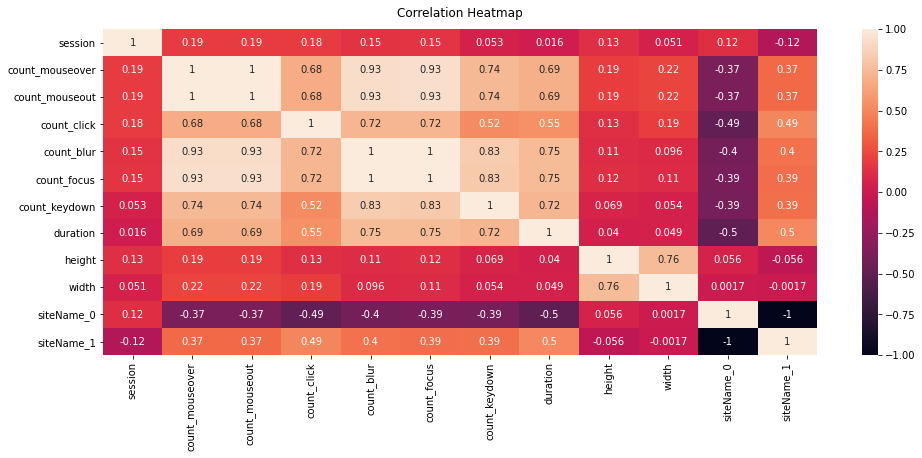

In [ ]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(one_hot_encoded_data_sessions.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### 3.3 Pairplot zur Darstellung von Korrelationen

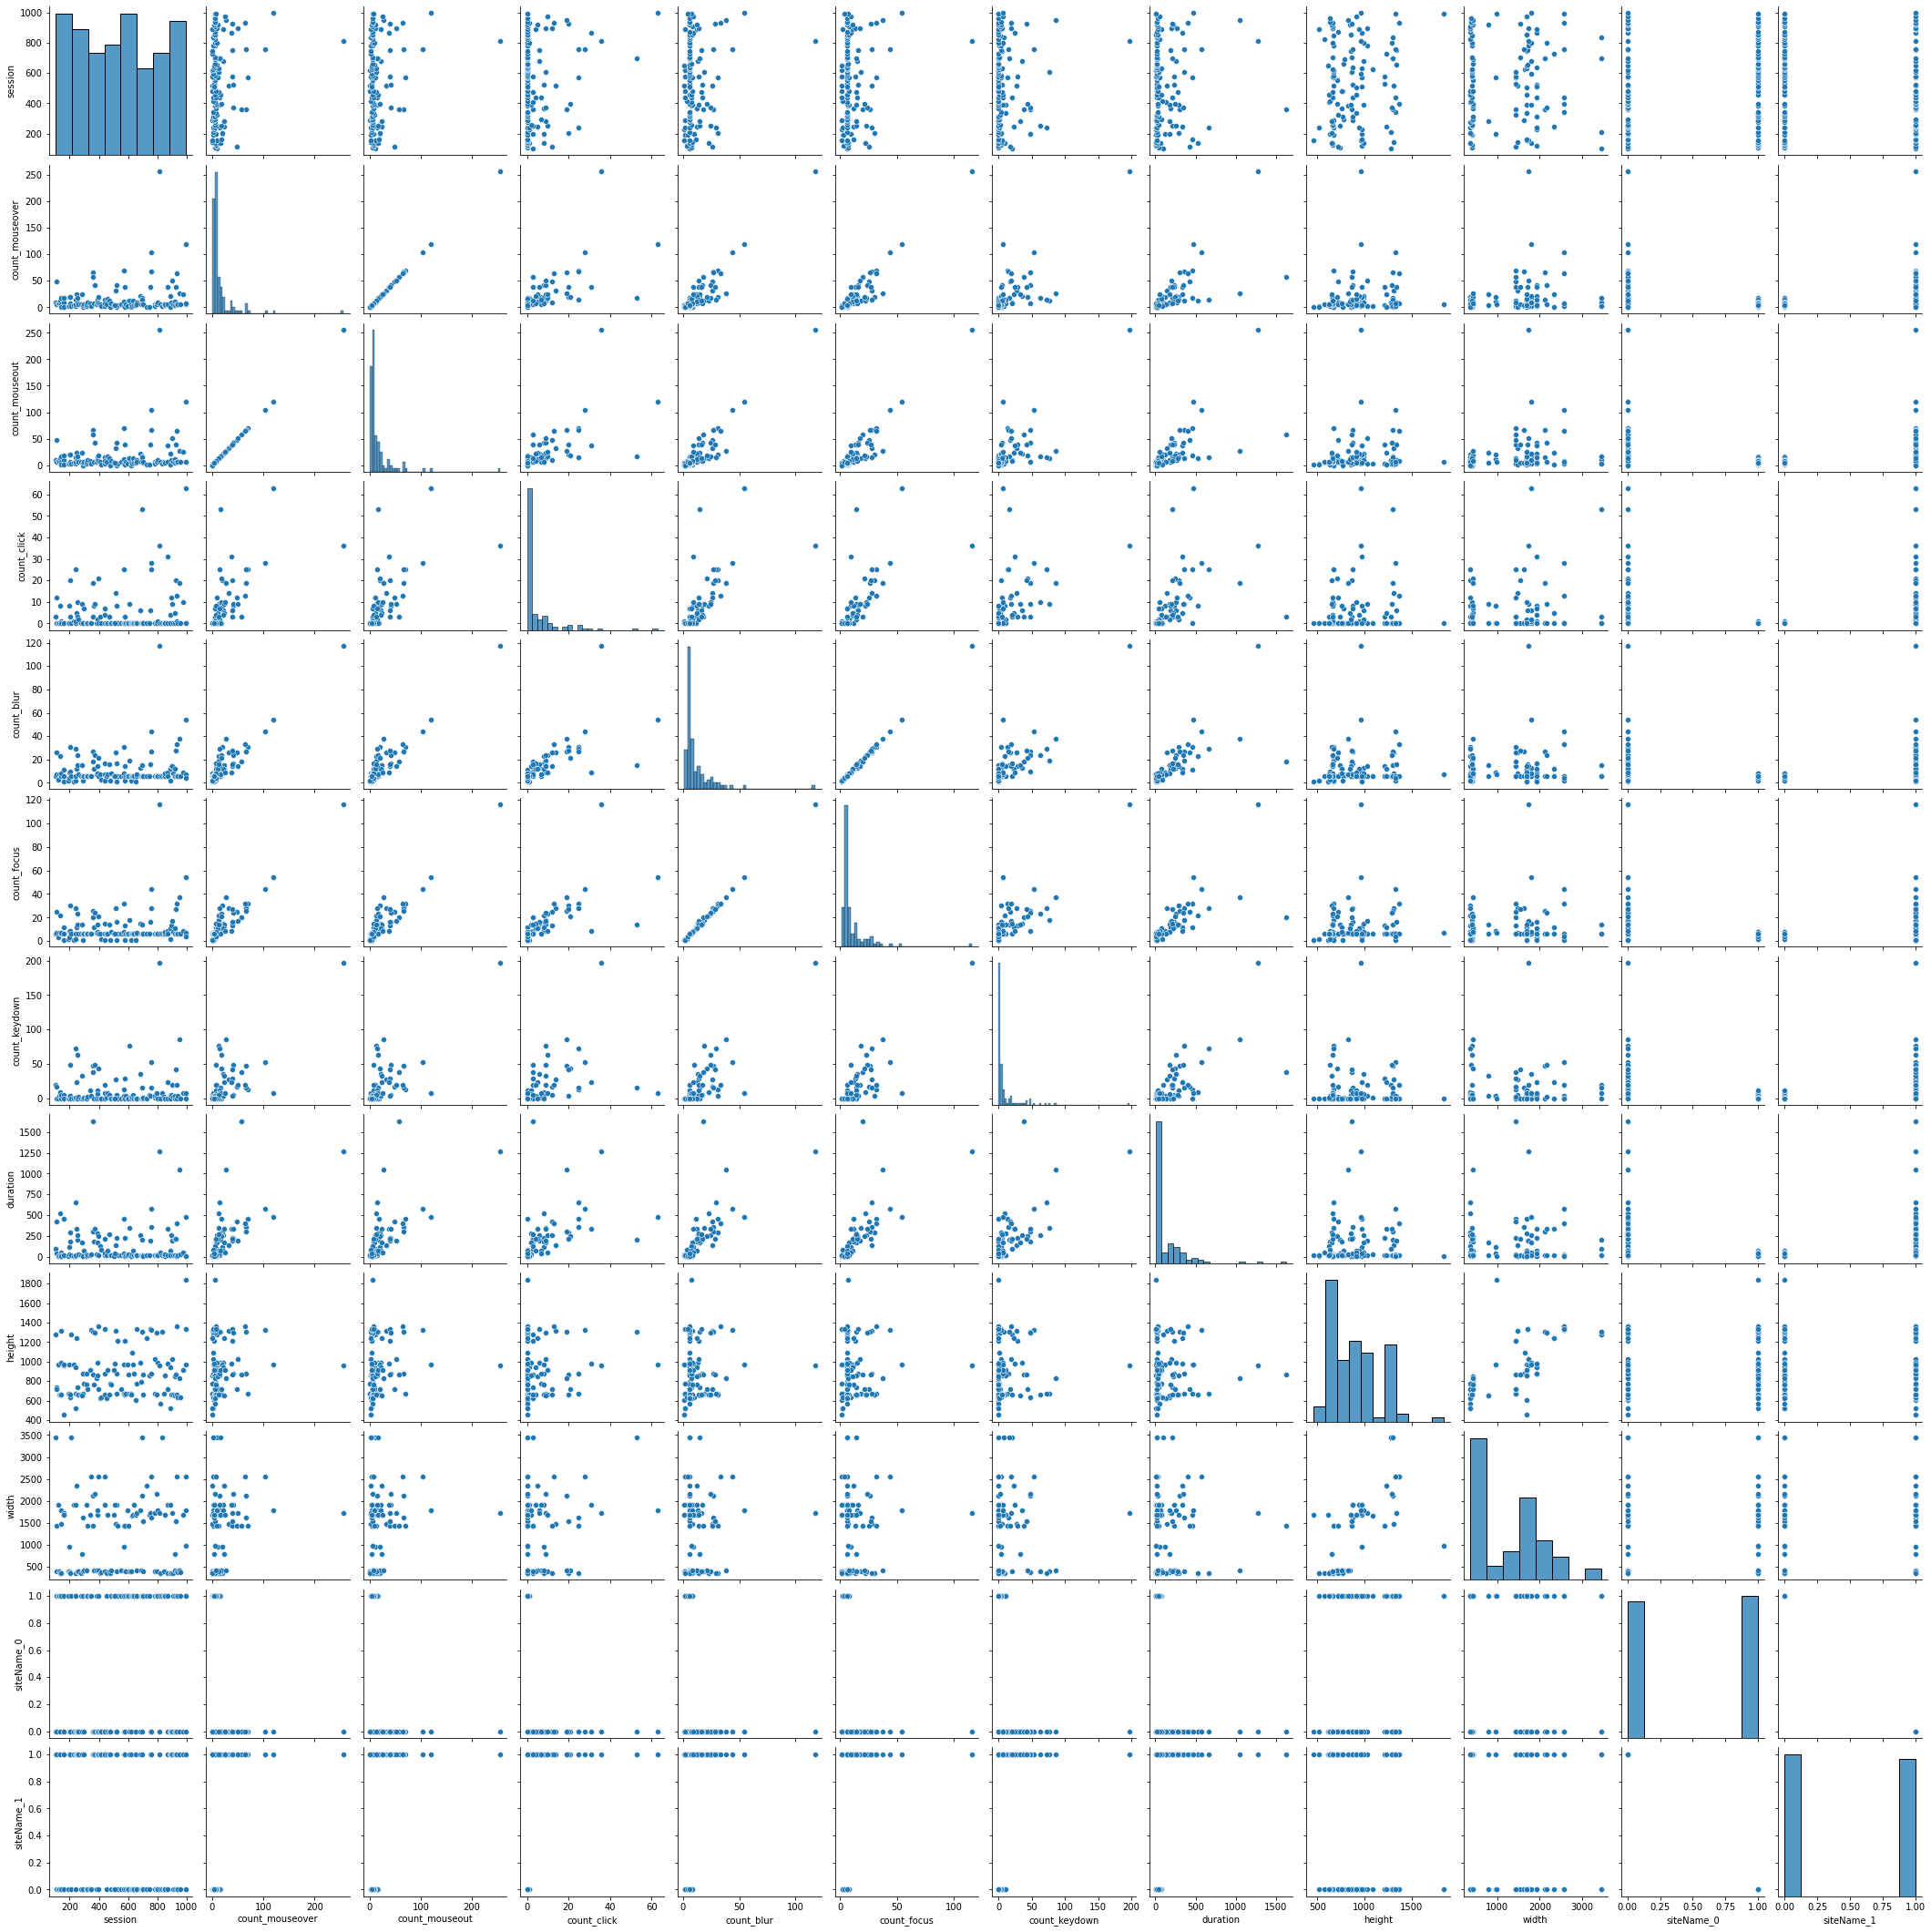

In [ ]:
sns.pairplot(one_hot_encoded_data_sessions)

In [ ]:
df_test = pd.read_pickle('SortedBySessions2.pkl')
df_test.head()

,session,count_mouseover,count_mouseout,count_click,count_blur,count_focus,count_keydown,count_all,duration,height,width,siteName,clientX,clientY
0,515,32,32,14,26,28,27,159,136.831,1312.0,1479.0,1,359.0,320.0
1,519,1,0,0,1,1,0,3,33.249,669.0,390.0,1,266.0,282.0
2,524,42,42,8,17,16,5,130,230.175,878.0,1920.0,1,674.0,468.0
3,528,4,3,0,6,6,0,19,20.563,1217.0,1440.0,0,397.0,469.0
4,554,6,6,0,6,6,0,24,17.076,715.0,414.0,0,346.0,301.0


In [ ]:
# einfach = schwero.loc[schwero['siteName'] == 'TestEinfach']
# einfach_key = einfach.loc[einfach['type'] == 'keydown']

# einfach_key['session'].count()

In [ ]:
# df_data_without_scroll = pd.concat([df_einfach_final, df_schwer_final])
# df_data_without_scroll = df_data_without_scroll.loc[df_data_without_scroll["type"] !="scroll"]
# df_tmp = shuffle(df_data_without_scroll)
# #df_tmp.to_pickle('CleanedDataWithoutChange.pkl')

In [ ]:
# df_einfach_final['type'].value_counts()

In [ ]:
# #count of easy
# # Figure size
# plt.figure(figsize=(9,7))
# # Count plot
# ax = sns.countplot(x = 'type', data = df_einfach_final, palette="coolwarm_r")
# # Add title
# plt.title('Counts for Types', fontsize=18)

In [ ]:
# df_schwer_final['type'].value_counts()

In [ ]:
# #count of easy
# # Figure size
# plt.figure(figsize=(9,7))
# # Count plot
# ax = sns.countplot(x = 'type', data = df_schwer_final, palette="coolwarm_r")
# # Add title
# plt.title('Counts for Types', fontsize=18)

In [ ]:
# df_schwer_final = df_schwer_final.loc[df_schwer_final["type"] !="scroll"]
# df_einfach_final = df_einfach_final.loc[df_einfach_final["type"] !="scroll"]

In [ ]:
# df2 = df_einfach_final.sort_values(['session', 'date'],
#               ascending = [True, True])

In [ ]:
# print(len(df_einfach_final))
# print(len(df_schwer_final))

# df_einfach_final['type'].value_counts()


In [ ]:
# df_schwer_final['type'].value_counts()

In [ ]:
# df_data_without_scroll = df_data_without_scroll.loc[df_data_without_scroll["type"] !="scroll"]
# df_data_without_scroll['siteName'] = df_data_without_scroll['siteName'].replace('TestSchwer', 1)
# df_data_without_scroll['siteName'] = df_data_without_scroll['siteName'].replace('TestEinfach', 0)

### Cleaned Data with other session Ids

In [ ]:
# # new sessionId 
# import random
# from random import choice
# import collections

# array_of_ids_einfach = df_einfach_final['session'].value_counts().index.tolist()
# array_of_ids_schwer = df_schwer_final['session'].value_counts().index.tolist()
# numbers_schwer = []

# random_numbers_ids_einfach = random.sample(range(101,1000), len(array_of_ids_einfach))
# for i in range(len(random_numbers_ids_einfach)):
#     random_numbers_ids_schwer = random.choice([i for i in range(101, 1000) if i not in random_numbers_ids_einfach])
#     numbers_schwer.append(random_numbers_ids_schwer)

# numbers = random_numbers_ids_einfach + numbers_schwer

# df_einfach_final['session'] = df_einfach_final['session'].replace(array_of_ids_einfach, random_numbers_ids_einfach)
# df_schwer_final['session'] = df_schwer_final['session'].replace(array_of_ids_schwer, numbers_schwer)

# print([item for item, count in collections.Counter(numbers).items() if count > 1])

In [ ]:
# df_new_ids = pd.concat([df_einfach_final, df_schwer_final])

In [ ]:
#df_new_ids.to_pickle('CleanedDataWithIds.pkl')

In [ ]:
# import imblearn
# print(imblearn.__version__)

In [ ]:
# df_sessions = pd.read_pickle('SortedBySessions.pkl')

In [ ]:
# df_sessions.head()

In [ ]:
# df_cleaned = pd.read_pickle('CleanedDataWithIds.pkl')


In [ ]:
# one_hot_encoded_data = pd.get_dummies(df_cleaned, columns = ['elementId', 'type'])

In [ ]:
# import seaborn as sns
# sns.scatterplot(data=df_cleaned, x="type", y="timeStamp", hue="siteName")

In [ ]:
# sns.scatterplot(data=df_data_without_scroll, x="timeStamp", y="type", hue="siteName")

In [ ]:
# einfach = df_data_without_scroll.loc[df_data_without_scroll['siteName'] == 0]
# schwer = df_data_without_scroll.loc[df_data_without_scroll['siteName'] == 1]

In [ ]:
# sns.scatterplot(data=df_data_without_scroll, x='timeStamp', y="type", hue="siteName")

In [ ]:
# plt.figure(figsize=(10,6))
# sns.scatterplot(data=df_data_without_scroll, x='timeStamp', y="type", hue="siteName", palette="Set2")

In [ ]:
# df_sessions.head

In [ ]:
# df_session_einfach = df_sessions.loc[df_sessions["siteName"] == "TestEinfach"]
# df_session_schwer = df_sessions.loc[df_sessions["siteName"] == "TestSchwer"]

In [ ]:
# #next Button wurde anscheinend nicht immer übertragen lol --> deswegen müssen wir schauen ob die gleich adresse auf der anderne Seite ist 
# df_test = df_einfach_final.loc[df_einfach_final['elementId'] == 'nextButton']
# print(df_test)

In [ ]:
# array_session_einfach = ['f3a6d5da-7857-ab9a-bcaf-ffa678540500', '0eb0e508-a337-0a7e-490d-5bb67ea8605a', '7e78ac93-8a2f-39d2-26a1-c41c7804b2e2', 'c9f551e4-927d-b2bf-aa77-6c49231d51df', 'edeac185-2198-1a32-1bf4-dd0816811064', 'd6e55e9b-a662-53a8-a261-4a0a362e30c3', '06d4d87e-940f-973f-a09f-74fff7d0b83a', '8abf06f5-52ae-6b8a-2203-b8e5967621d3', '51f4db5a-4b60-df29-b773-12ad99d4781e', '0a0fdcc9-ebf8-371b-40bf-efe88d97e22e', 'f4fd1505-cec6-5f69-18de-bceac07666e6', 'c84ddb60-e23a-cd84-ab83-ba030d4c4a73', 'fba8ac2f-02c2-130b-254f-3bcebe67d451', 'f090c908-bb4c-fdca-942d-6ae02b4019b0', '62c1e7a3-3ae8-ea78-a6fa-5b0c8e6a4b90', 'a8edf9d6-fb31-5690-e4be-3fa68ae2ff4a', 'ce22d53f-16a7-8e19-de32-641cffee9cae', 'c2fccaf4-aa23-d3bb-291b-2ce8e083512a', 'cde8b105-35ba-2b75-2f62-7d2d538c9dca', '047b635d-224e-f897-c995-3a9cac2df78a', '5db6c1c8-a5d3-37a1-848e-71c29c4dd002', 'b66c82e2-5869-5ecc-0d81-1c7d55671ec8', '7fe95a48-d9bd-2059-b731-0da1e54a4618']
# df_click_einfach = df_einfach[df_einfach['session'].isin(array_session_einfach)]

# #df_click_einfach['session'].value_counts()

# df_click_einfach.loc[df_click_einfach['elementId'] == 'inputEasyQuestion']
# df_click_einfach.sort_values(['session', 'timeStamp'])
# df_sroll = df_click_einfach.loc[df_click_einfach["type"] !="scroll"]

# df_sroll['session'].value_counts()


# # df_click_einfach.sort_values(['session', 'timeStamp'])
# # df = df_click_einfach.loc[df_click_einfach['elementId'] == 'inputEasyQuestion']